# Running Milopy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import gmtime, strftime
strftime("%Y-%m-%d %H:%M:%S", gmtime())

'2022-08-03 12:50:59'

In [3]:
date = "2022-07-29"

In [4]:
mainDir = "/mnt/gmi-analysis01/_90.User_Data/juhyunk/project/schizophrenia/scRNA/singleCellAnalysis_byLibrary/"

In [5]:
import os
os.environ['R_HOME'] = "/gmi-l1/_90.User_Data/juhyunk/anaconda3/envs/scRNA_python/lib/R"

In [6]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import milopy
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

import milopy.core as milo
import milopy.plot as milopl

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
import seaborn as sb
from itertools import compress
import random
import joblib as jl
import matplotlib.patches as mpatches
#import genes
# import panfetal_utils

In [8]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()
%load_ext rpy2.ipython

In [9]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)
library(dplyr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [10]:
def annotate_nhoods(adata, anno_col):
    anno_dummies = pd.get_dummies(adata.obs[anno_col])
    anno_count = adata.obsm["nhoods"].T.dot(scipy.sparse.csr_matrix(anno_dummies.values))
    anno_frac = np.array(anno_count/anno_count.sum(1))

    anno_frac = pd.DataFrame(anno_frac, 
                             columns=anno_dummies.columns,
                             index=adata.uns["nhood_adata"].obs_names
                            )
    adata.uns["nhood_adata"].obsm["frac_annotation"] = anno_frac.values
    adata.uns["nhood_adata"].uns["annotation_labels"] = anno_frac.columns
    adata.uns["nhood_adata"].obs["nhood_annotation"] = anno_frac.idxmax(1)
    adata.uns["nhood_adata"].obs["nhood_annotation_frac"] = anno_frac.max(1)

# Loading Data

In [11]:
adata = sc.read_h5ad(mainDir + "scvi_integrated/" + date + "/scanpy/scvi_integrated.velocyto.cellcycle.3Dumap.h5ad")

In [12]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 70, key_added="scvi",n_pcs = 50)

## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.1)

## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="sample")

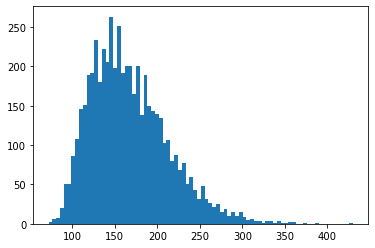

In [13]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=80);

# Testing Milopy

In [14]:
adata.obs['condition'] = adata.obs['condition'].astype("category")
milopy.utils.add_covariate_to_nhoods_var(adata, ['condition'])
adata.uns['nhood_adata'].var['condition'] = adata.uns['nhood_adata'].var['condition'].astype('category')
all_condition = adata.obs.condition.unique().tolist()
design = '~ condition'

## Calculate logFC and SpatialFDR within each organ
milo_res_dict = {}

In [15]:
for cond in all_condition:
    print(cond)
    if cond == adata.uns['nhood_adata'].var.condition.cat.categories[0]:
        nhood_adata = adata.uns['nhood_adata'].copy()
        new_cats = nhood_adata.var.condition.cat.categories[1:].tolist()
        new_cats.append(cond)
        nhood_adata.var.condition.cat.reorder_categories(new_cats, inplace=True)
        adata.obs.condition.cat.reorder_categories(new_cats, inplace=True)
        adata.uns['nhood_adata'] = nhood_adata.copy()
#     _milo_test_organ_abundance(adata, org, design)
    milo.DA_nhoods(adata, design=design ,model_contrasts='condition{o}'.format(o=cond))
    milo_res_dict[cond] = adata.uns["nhood_adata"].obs.copy()

CTR
GHR
SPR


In [16]:
## Collapse results
logFC_df_ls = [v["logFC"] for k,v in milo_res_dict.items()]
for k,v in milo_res_dict.items():
    milo_res_dict[k]["logFC_" + k] = milo_res_dict[k]["logFC"].copy()
    milo_res_dict[k]["SpatialFDR_" + k] = milo_res_dict[k]["SpatialFDR"].copy()

org_fc = pd.concat([v[["logFC_" + k]] for k,v in milo_res_dict.items()], 1)
org_fdr = pd.concat([v[["SpatialFDR_" + k]] for k,v in milo_res_dict.items()], 1)

In [17]:
org_fc_filtered = org_fc.copy()
org_fc_filtered.values[org_fdr.values > 0.1] = 0

In [18]:
## Add annotation
annotate_nhoods(adata, anno_col="Cluster")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

# org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

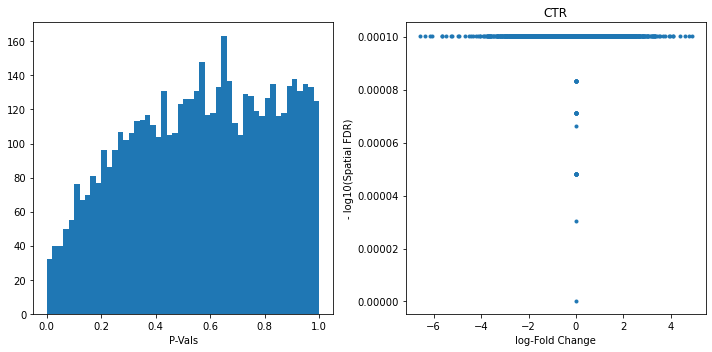

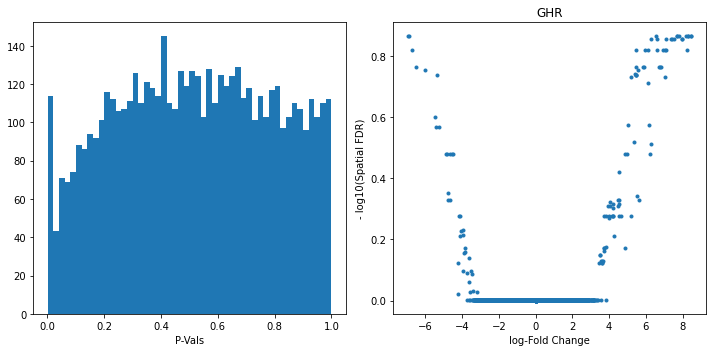

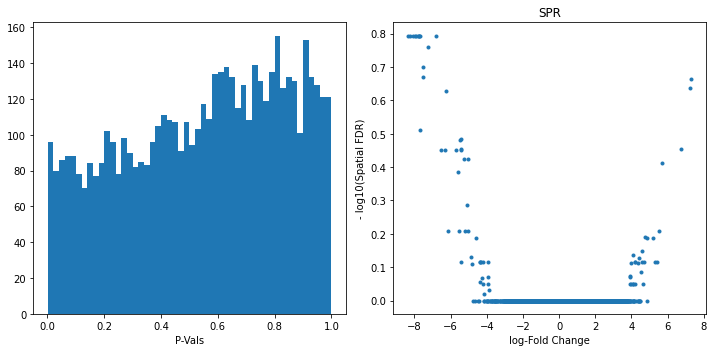

In [19]:
old_figsize = plt.rcParams["figure.figsize"]
for org, milo_res in milo_res_dict.items():
    plt.rcParams["figure.figsize"] = [10,5]
    plt.subplot(1,2,1)
    plt.hist(milo_res.PValue, bins=50);
    plt.xlabel("P-Vals");
    plt.subplot(1,2,2)
    plt.plot(milo_res.logFC, -np.log10(milo_res.SpatialFDR), '.');
    plt.xlabel("log-Fold Change");
    plt.ylabel("- log10(Spatial FDR)");
    plt.title(org);
    plt.tight_layout();
    plt.show()

plt.rcParams["figure.figsize"] = old_figsize

In [20]:
milopy.utils.build_nhood_graph(adata)

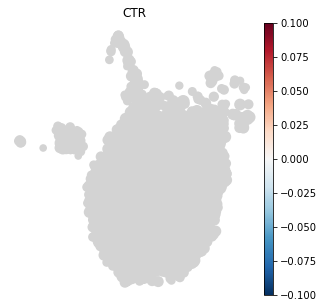

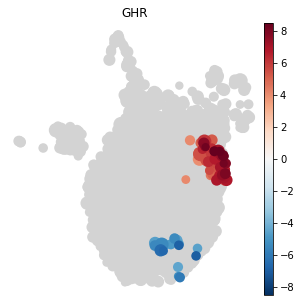

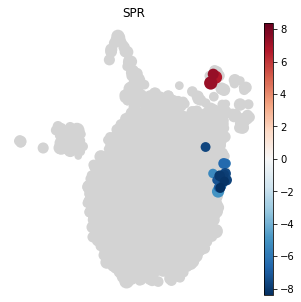

In [21]:
plt.rcParams["figure.figsize"] = [5,5]
milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    milopl.plot_nhood_graph(adata, alpha=0.5, min_size=3, title=org,  save="milo_nhoods_graph_{o}.png".format(o=org))

In [22]:
milopy.utils.annotate_nhoods(adata, anno_col='Cluster')

Text(0.5, 0, 'celltype fraction')

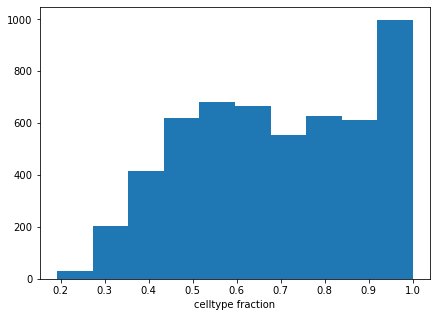

In [23]:
plt.rcParams["figure.figsize"] = [7,5]
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

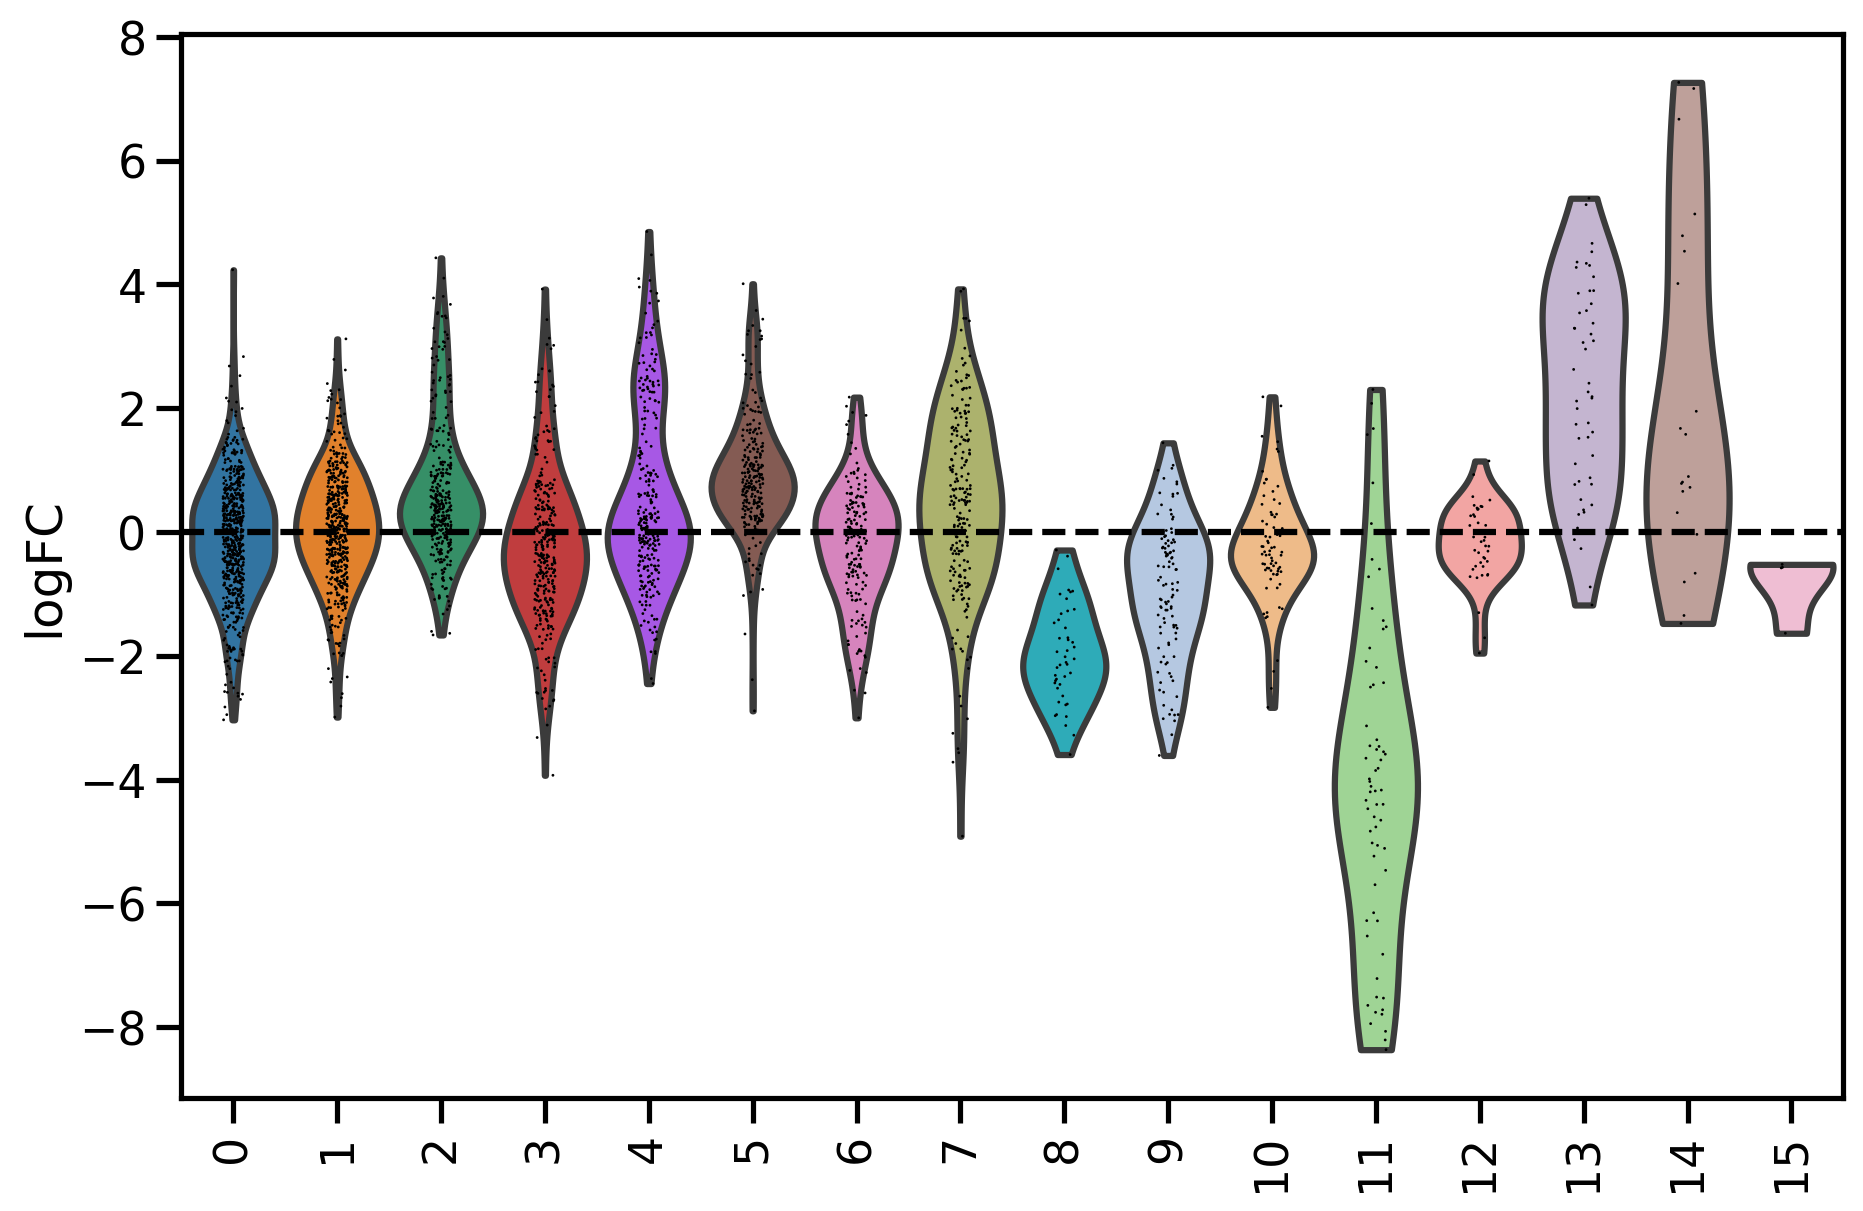

In [127]:
plt.rcParams["figure.figsize"] = [9,7]
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

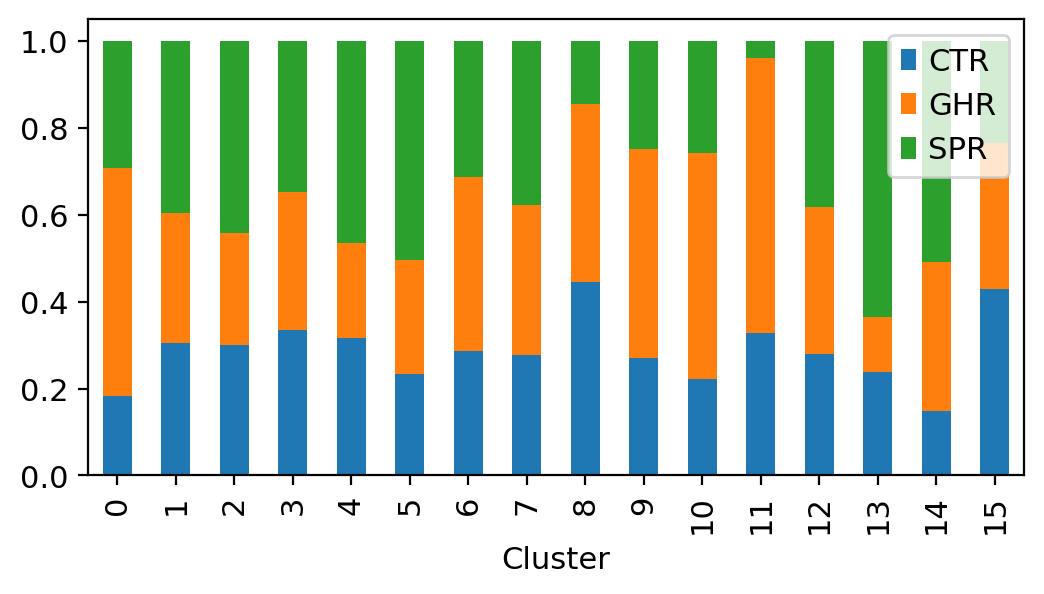

In [28]:
plt.rcParams["figure.figsize"] = [6,3]
tmp = pd.crosstab(adata.obs['Cluster'],adata.obs['condition'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='upper right')

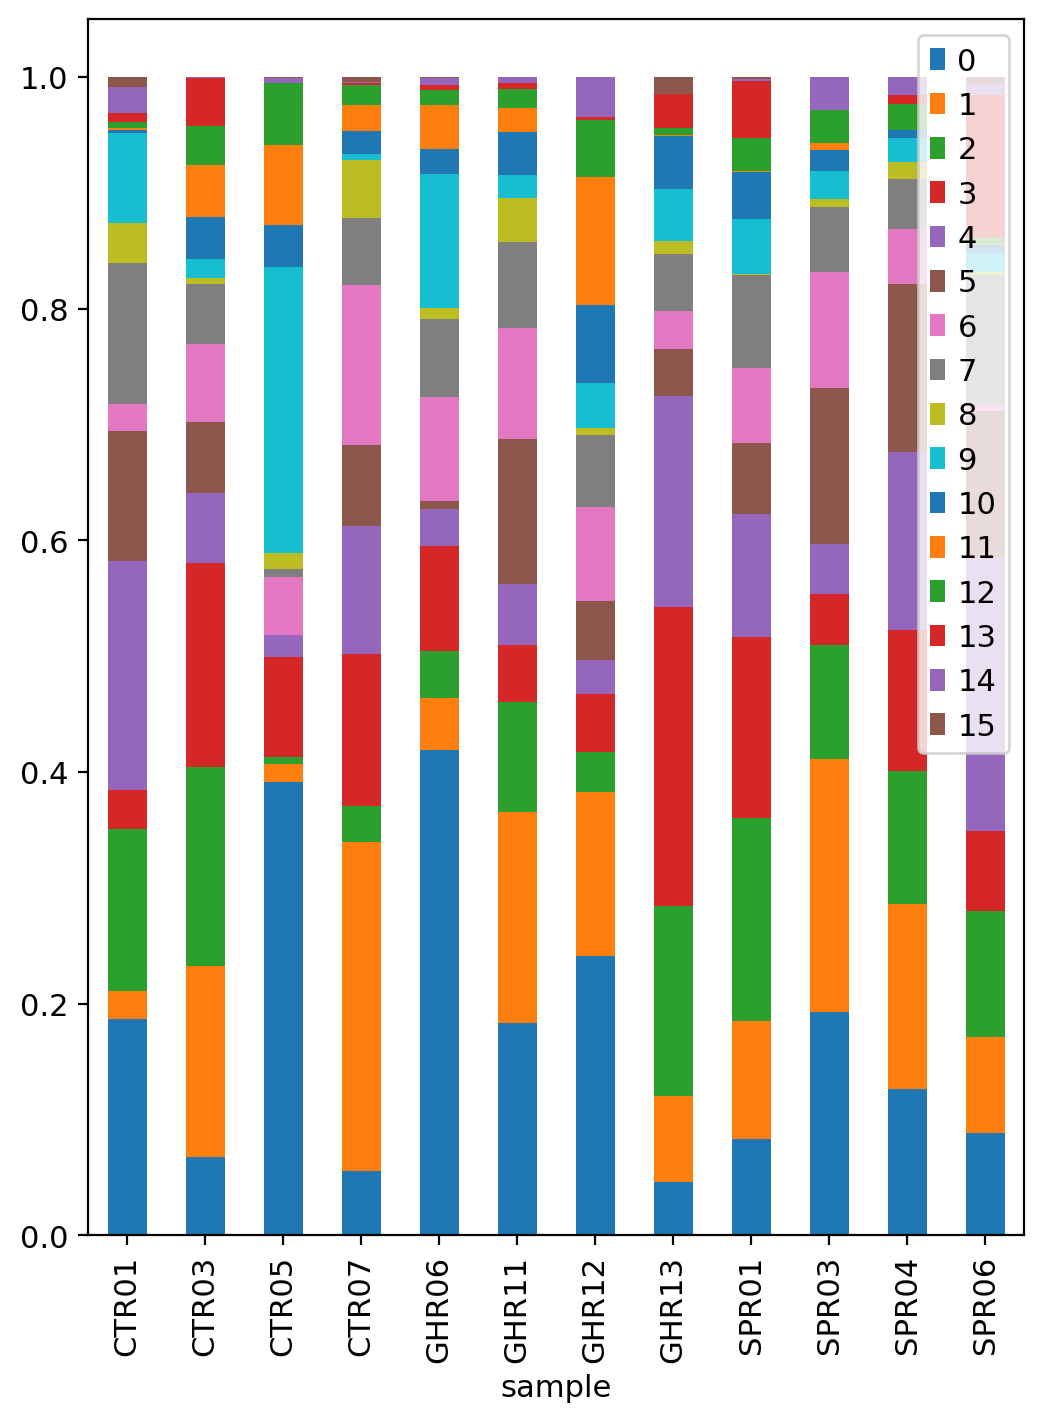

In [29]:
plt.rcParams["figure.figsize"] = [6,8]
tmp = pd.crosstab(adata.obs['sample'],adata.obs['Cluster'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='upper right')

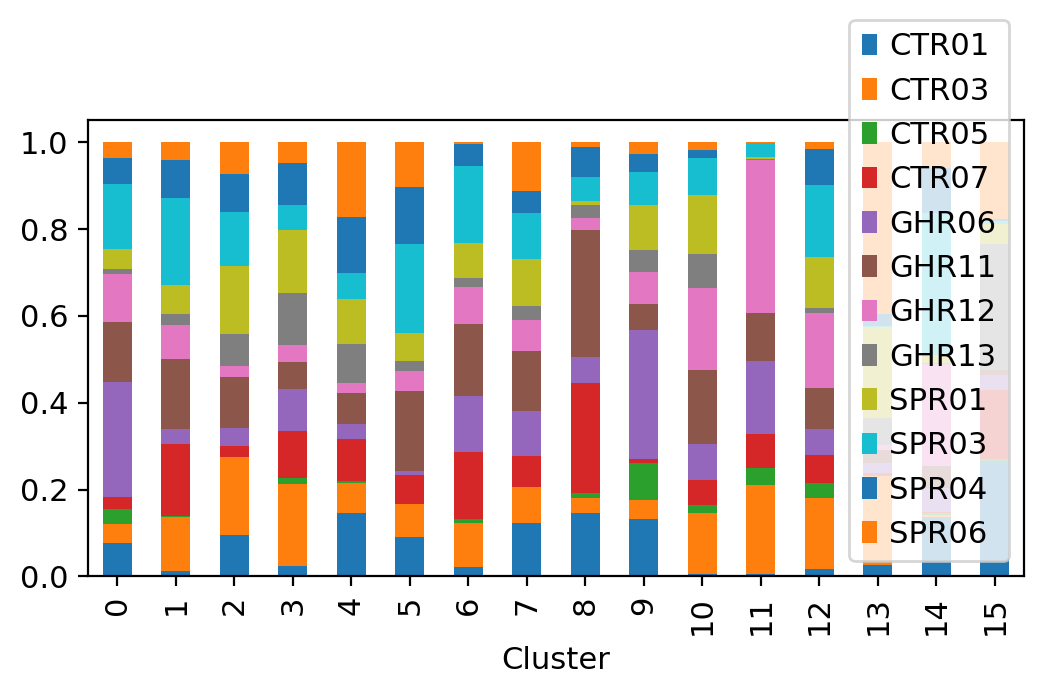

In [30]:
plt.rcParams["figure.figsize"] = [6,3]
tmp = pd.crosstab(adata.obs['Cluster'],adata.obs['sample'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='best')

In [48]:
nhood_adata = adata.uns['nhood_adata']

In [49]:
nhood_adata.obs["nhood_annotation"] = adata.obs.filter(items = nhood_adata.obs["index_cell"], axis = 0)["Cluster"].tolist()

In [50]:
milopy.utils.build_nhood_graph(adata)

In [51]:
alpha = 0.01
min_logFC = 2
min_size=0.5
plot_edges = False

In [52]:
def plot_nhood_graph_enrichment(nhood_adata, alpha = 0.01,
    min_logFC = 2,
    min_size=0.5,
    plot_edges = False,
    title='ciao',**kwargs):
#     nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = nhood_adata.obs["logFC"]
    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan
    nhood_adata.obs["abs_logFC"] = abs(nhood_adata.obs["logFC"])
    nhood_adata.obs.loc[nhood_adata.obs["abs_logFC"] < min_logFC, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] < 0, "graph_color"] = np.nan

    ## Plotting order - extreme logFC on top
    nhood_adata.obs.loc[nhood_adata.obs["graph_color"].isna(), "abs_logFC"] = np.nan
    ordered = nhood_adata.obs.sort_values('abs_logFC', na_position='first').index
    nhood_adata = nhood_adata[ordered]

#     vmax = np.max([nhood_adata.obs["graph_color"].max(), abs(nhood_adata.obs["graph_color"].min())])
    vmin = 0

    sc.pl.embedding(nhood_adata, "X_milo_graph", 
                    color="graph_color", cmap="Reds",
                    size=nhood_adata.obs["Nhood_size"]*min_size, 
                    edges=plot_edges, neighbors_key="nhood",
                    # edge_width = 
                    sort_order=False,
                    frameon=False,
#                     vmax=vmax, 
                    vmin=vmin,
                    title=title,
                    **kwargs
                   )

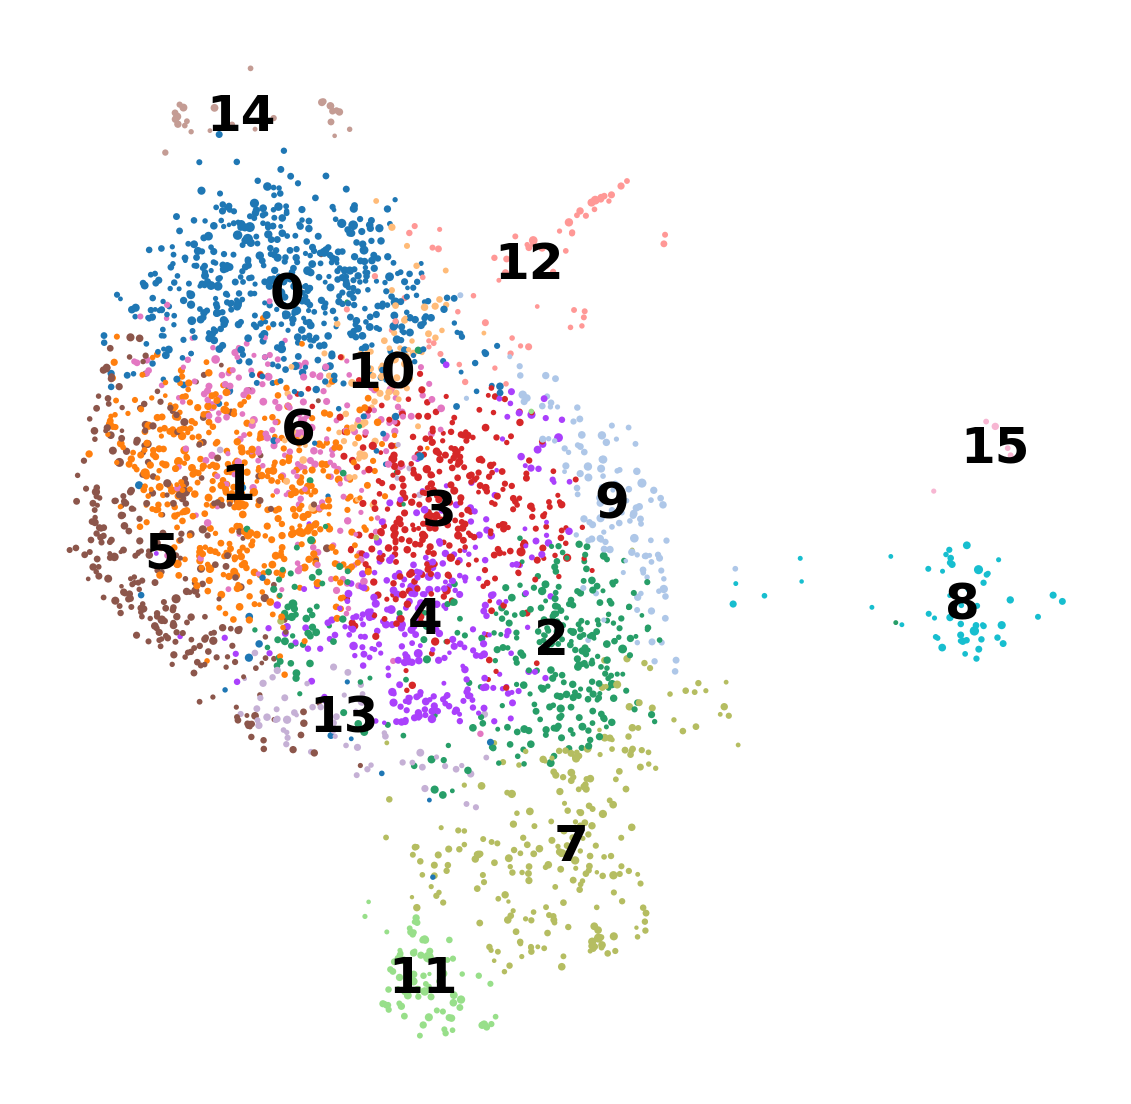

In [53]:
vmin = 0

plt.rcParams["figure.figsize"] = [7,7]
sns.set_context("talk")
sc.pl.embedding(nhood_adata, "X_milo_graph", 
                color="nhood_annotation",
                size=nhood_adata.obs["Nhood_size"]*min_size, 
                edges=plot_edges, neighbors_key="nhood",
                # edge_width = 
                sort_order=False,
                frameon=False,
#                     vmax=vmax, 
                vmin=vmin,
                title='',
                legend_loc="on data",
                save='nhood_graph_mono_anno.pdf'
               )

plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")

# milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    annotate_nhoods(adata, anno_col="Cluster")
    nhood_adata = adata.uns["nhood_adata"].copy()
    plot_nhood_graph_enrichment(nhood_adata, alpha=0.01, min_logFC= 2, min_size=0.5, title=org, 
                                save='nhood_graph_{o}.pdf'.format(o=org))


In [67]:
%%R -i org_fc_filtered -i org_fdr -h 1000 -w 800
org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    head()

  Nhood logFC_CTR logFC_GHR logFC_SPR
1     1         0         0         0
2     2         0         0         0
3     3         0         0         0
4     4         0         0         0
5     5         0         0         0
6     6         0         0         0


In [130]:
# Visualize with beeswarm plot

In [73]:
%%R -i org_fc_filtered -i org_fdr -h 1000 -w 800

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 



Error in `chr_as_locations()`:
! Can't subset columns that don't exist.
✖ Column `anno_group` doesn't exist.
Run `rlang::last_error()` to see where the error occurred.

chr_as_locations(x, vars, call = call)에서 다음과 같은 에러가 발생했습니다:


RInterpreterError: Failed to parse and evaluate line '\nlong_org_fc <- org_fc_filtered %>%\n    rowid_to_column("Nhood") %>%\n    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%\n    mutate(organ=str_remove(organ, "logFC_")) \n\nlong_org_fdr <- org_fdr %>%\n    rowid_to_column("Nhood") %>%\n    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%\n    mutate(organ=str_remove(organ, "SpatialFDR_")) \n\n'.
R error message: 'chr_as_locations(x, vars, call = call)에서 다음과 같은 에러가 발생했습니다:'

In [54]:
%%R -i org_fc_filtered -i org_fdr -h 1000 -w 800

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 
    
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ## Fix some names
    mutate(nhood_anno=ifelse(str_detect(nhood_anno, "NK$"), "NK", nhood_anno)) %>%
    ## Reorder by fold-change 
    group_by(organ, nhood_anno, Nhood) %>%
    mutate(mean_logFC = mean(logFC)) %>%
    ungroup() %>%
    group_by(organ, nhood_anno) %>%
    arrange(- mean_logFC) %>%
    ungroup()  %>%
    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
    group_by(nhood_anno) %>%
    filter(length(unique(Nhood)) > 20) %>%
    ungroup()

unique(plot_df$anno_group)

Error in `chr_as_locations()`:
! Can't subset columns that don't exist.
✖ Column `nhood_anno` doesn't exist.
Run `rlang::last_error()` to see where the error occurred.

chr_as_locations(x, vars, call = call)에서 다음과 같은 에러가 발생했습니다:


RInterpreterError: Failed to parse and evaluate line '\nlong_org_fc <- org_fc_filtered %>%\n    rowid_to_column("Nhood") %>%\n    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%\n    mutate(organ=str_remove(organ, "logFC_")) \n\nlong_org_fdr <- org_fdr %>%\n    rowid_to_column("Nhood") %>%\n    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%\n    mutate(organ=str_remove(organ, "SpatialFDR_")) \n    \nplot_df <- left_join(long_org_fc, long_org_fdr) %>%\n    filter(!is.na(logFC)) %>%\n    filter(nhood_anno!="nan") %>%\n    filter(nhood_anno!="Mixed") %>%\n    ## Fix organ naming and order \n    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%\n    ## Fix some names\n    mutate(nhood_anno=ifelse(str_detect(nhood_anno, "NK$"), "NK", nhood_anno)) %>%\n    ## Reorder by fold-change \n    group_by(organ, nhood_anno, Nhood) %>%\n    mutate(mean_logFC = mean(logFC)) %>%\n    ungroup() %>%\n    group_by(organ, nhood_anno) %>%\n    arrange(- mean_logFC) %>%\n    ungroup()  %>%\n    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%\n    group_by(nhood_anno) %>%\n    filter(length(unique(Nhood)) > 20) %>%\n    ungroup()\n\nunique(plot_df$anno_group)\n'.
R error message: 'chr_as_locations(x, vars, call = call)에서 다음과 같은 에러가 발생했습니다:'

In [ ]:
%%R -w 1200 -h 600 -i figdir -o pl_df
library(ggbeeswarm)
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

anno_group_order <- c('Progenitors', "ILCs", "NK cells","B cells" ,"T cells")

pl_df <- plot_df %>%
    mutate(logFC=ifelse(logFC > 0, logFC, 0)) %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% anno_group_order)
In [40]:


In [ ]:
%R -w 1200 -h 600
alpha=0.1
set.seed(12345)
pl1 <- 
    pl_df %>%
    mutate(organ_color=ifelse((SpatialFDR < alpha) & (logFC > 0), as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
#     geom_quasirandom(size=0.2, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.4, aes(color=organ_color)) +
#     geom_violin(data=. %>% filter(SpatialFDR < alpha), aes(color=organ_color)) +
#     geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
    theme_bw(base_size=18) +
    xlab("") + ylab("DA log-Fold Change") +
    theme(strip.text.y=element_text(angle=0))
    
pl1
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

In [89]:
adata.write_h5ad(mainDir + "scvi_integrated/" + date + "/scanpy/scvi_integrated.velocyto.cellcycle.milopy.h5ad")